In [1]:
%matplotlib inline
import gurobipy as grb
import pandas as pd
import numpy as np

In [18]:
data = pd.read_csv('../../../data/third_party_preds/betegy-121115.csv')
data.columns, data.head()
list_of_bookmakers = ['b365', 'bwin']

In [89]:
# p_games = data[['Home Win', 'Home Draw', 'Home Lost']]
# num_of_games = p_games.shape[0]

# num_of_results = 3

# b365 = data[['b365H', 'b365D', 'b365A']]
# bwin = data[['bwinH', 'bwinD', 'bwinA']]
# bookmakers = [b365, bwin]
# num_of_bookmakers = len(bookmakers)
# head_to_head = data['Home vs Away']
# names = [['b365'] * num_of_games + ['bwin'] * num_of_games,
#           list(head_to_head) * num_of_bookmakers]
# bookmakers = pd.DataFrame(np.concatenate([b365.values, bwin.values]), index=names, columns=['Home', 'Draw', 'Away'])
# bookmakers.ix['b365']


In [13]:
def kelly_criterion(p, odd):
    return p - (1 - p) / (odd - 1)

In [96]:
def solve(total_budget, single_bet_budget, data, list_of_bookmakers):
    """
    Main solver to solve the betting strategy problem
    """
    
    
    ###################################################################
    ### Step 1: Config parameters: p_games, bookmakers, kelly, etc. ###
    ###################################################################
    
    # p_games: probability of each game result
    p_games = data[['Home Win', 'Home Draw', 'Home Lost']]
    num_of_games = p_games.shape[0]

    # Bookmakers
    num_of_results = 3
    all_bookmaker_odds = []
    for bookmaker in list_of_bookmakers:
        bookmaker_odds = data[[bookmaker + 'H', bookmaker + 'D', bookmaker + 'A']]
        all_bookmaker_odds.append(bookmaker_odds)
        
    b365 = data[['b365H', 'b365D', 'b365A']]
    bwin = data[['bwinH', 'bwinD', 'bwinA']]
    bookmakers = [b365, bwin]
    num_of_bookmakers = len(list_of_bookmakers)
    head_to_head = data['Home vs Away']
    first_level_idx = []
    for bookmaker in list_of_bookmakers:
        first_level_idx += [bookmaker] * num_of_games   
    second_level_idx = list(head_to_head) * num_of_bookmakers
    
    index = [first_level_idx, second_level_idx]
    bookmakers = pd.DataFrame(np.concatenate([bookmaker_odds.values for bookmaker_odds in all_bookmaker_odds]), 
                              index=index, columns=['Home', 'Draw', 'Away'])

    # Game Result, pandas data frame, with index as "a vs b", and columns as "Home Win","Home Draw", "Home Lost"
    result = pd.get_dummies(data, columns=['result'])[['result_1', 'result_2', 'result_3']]
    result = result.set_index(head_to_head.values)
    result.rename(columns = {'result_1' : 'Home Win', 'result_2' : 'Home Draw', 'result_3' : 'Home Lost'}, inplace=True)

    # Extract the values as numpy arraies from data frames. 
    p_games_val = p_games.values
    bookmakers_val = np.zeros((num_of_games, num_of_results, num_of_bookmakers))    
    for i in np.arange(num_of_bookmakers):
        bookmakers_val[:, :, i] = bookmakers.ix[list_of_bookmakers[i]].values
           
    # Kelly, bookmakers, and probabilities of the results of each game, put into a dict
    kellies = {}
    bookmaker_row_vector = {}
    prob_row_vector = {}
    
    
    ##############################################################################
    ### Step 2: Use Gurobi solver, model the optimization problem and solve it ###
    ##############################################################################
    
    # Create Gurobi Model
    m = grb.Model('betting strategy')
    
    # Create decision variables for the betting strategy, which are binary vars
    # either bet this one or not. The price to bet is the corresponding kelly criteria value
    # Also populate the parameters here
    bet = {}   # bianry decision var
    bet_idx = 0
    n = 0
    for i in np.arange(num_of_games):
        for j in np.arange(num_of_bookmakers):
            for k in np.arange(num_of_results):
                p = p_games_val[i, k]
                odd = bookmakers_val[i, k, j]
                kelly = kelly_criterion(p, odd)
                bet_name = head_to_head[i] + ',' + p_games.columns[k] + ',' + list_of_bookmakers[j]
                kellies[bet_name] = kelly
                bookmaker_row_vector[bet_name] = odd
                prob_row_vector[bet_name] = p                
                bet[bet_name] = m.addVar(vtype = grb.GRB.BINARY, name=bet_name)
                              
                bet_idx += 1
                
    m.update()
    
    # Add constraint: bet_i * kelly * single_bet_budget >= 0, otherwise we don't bet on it
    for bet_name in bet.keys():
        m.addConstr(bet[bet_name] * kellies[bet_name] * single_bet_budget >= 0, 
                    'we must bet on positive kelly games: ' + bet_name )
        
    # Add constraint: Total_bet <= total_budget
    m.addConstr(
        grb.quicksum(bet[bet_name] * kellies[bet_name] * single_bet_budget for bet_name in bet.keys()) <= total_budget, 
        'Total_bet <= total_budget')
    
    # Add objective function: maximize profit
    m.setObjective(
        grb.quicksum(bet[bet_name] * kellies[bet_name] * single_bet_budget * (bookmaker_row_vector[bet_name] - 1) 
                     for bet_name in bet.keys()), grb.GRB.MAXIMIZE)
    
    # solve the optimization problem
    m.params.OutputFlag = 0
    m.optimize()
    
    ###########################
    ### Step 3: Get results ###
    ###########################
    
    actual_bets = {bet_name : bet[bet_name].x * kellies[bet_name] * single_bet_budget for bet_name in bet.keys()}
    
    expected_received = sum(bet[bet_name].x * kellies[bet_name] * single_bet_budget 
                                * bookmaker_row_vector[bet_name] * prob_row_vector[bet_name]  
                                for bet_name in bet.keys())
    expected_profit = expected_received - sum(actual_bets.values())
    
    potential_received = {bet_name : bet[bet_name].x * kellies[bet_name] * single_bet_budget 
                          * bookmaker_row_vector[bet_name] for bet_name in bet.keys()}
    
    actual_received = {bet_name: bet[bet_name].x * kellies[bet_name] * single_bet_budget 
                       * bookmaker_row_vector[bet_name] 
                       if result.ix[bet_name.split(',')[0], bet_name.split(',')[1]] == 1
                      else 0 for bet_name in bet.keys()}
    
    actual_profit = sum(actual_received.values()) - sum(actual_bets.values())
    return expected_profit, actual_profit, actual_bets

In [97]:
total_budget = 1000
single_bet_budget = 300
list_of_bookmakers = ['b365', 'bwin']
expected_profit, actual_profit, actual_bets = solve(total_budget, single_bet_budget, data, list_of_bookmakers)

In [98]:
expected_profit, actual_profit

(1541.5223265500204, 112.95938817266517)

In [99]:
result_dict = {'total_budget' : [], 'single_bet_budget' : [], 'expected_profit' : [], 'actual_profit' : []}

In [110]:
for total_budget in np.arange(100, 1000, 25):
    for single_bet_budget in np.arange(50, 300, 25):
        expected_profit, actual_profit, actual_bets = solve(total_budget, single_bet_budget, data, list_of_bookmakers)
        result_dict['total_budget'].append(total_budget)
        result_dict['single_bet_budget'].append(single_bet_budget)
        result_dict['expected_profit'].append(expected_profit)
        result_dict['actual_profit'].append(actual_profit)

betting_tracker = pd.DataFrame(result_dict)
betting_tracker.head()

,actual_profit,expected_profit,single_bet_budget,total_budget
0,85.460769,200.310050,50,100
1,-98.231717,267.301592,100,100
2,-99.946019,330.824546,150,100
3,-96.474545,374.421073,200,100
4,-99.950144,388.272268,250,100


array([[<matplotlib.axes.AxesSubplot object at 0x7fe45a2cfeb8>]], dtype=object)

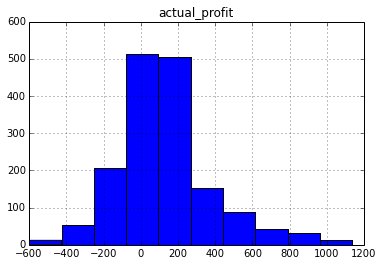

In [111]:
betting_tracker.hist(column='actual_profit')

0.94166666666666665

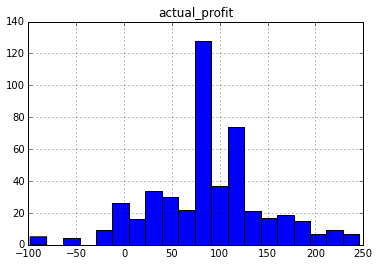

In [116]:
betting_tracker_copy = betting_tracker.copy()
betting_tracker_copy = betting_tracker_copy[betting_tracker_copy['single_bet_budget'] <= 100]
betting_tracker_copy.hist(column='actual_profit', bins = 20)
np.mean(betting_tracker_copy['actual_profit'] > 0)

0.92880794701986757

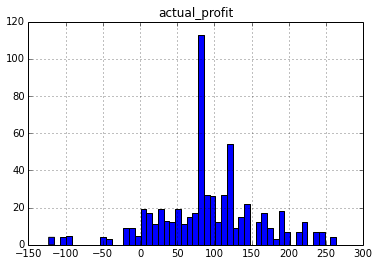

In [120]:
betting_tracker_copy = betting_tracker.copy()
betting_tracker_copy = betting_tracker_copy[betting_tracker_copy['single_bet_budget'] <= 125]
betting_tracker_copy.hist(column='actual_profit', bins = 50)
np.mean(betting_tracker_copy['actual_profit'] > 0)

0.80380673499267941

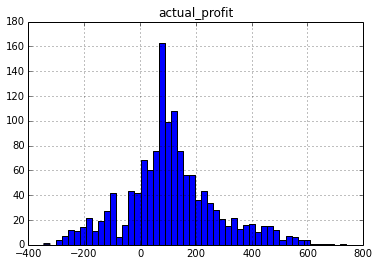

In [127]:
betting_tracker_copy = betting_tracker.copy()
betting_tracker_copy = betting_tracker_copy[betting_tracker_copy['single_bet_budget'] <= 300]
betting_tracker_copy.hist(column='actual_profit', bins = 50)
np.mean(betting_tracker_copy['actual_profit'] > 0)